In [117]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras import models, layers


In [118]:
races = pd.read_csv("dataset/races.csv")
drivers = pd.read_csv("dataset/drivers.csv")
constructors = pd.read_csv("dataset/constructors.csv")
results = pd.read_csv("dataset/results.csv")
circuits = pd.read_csv("dataset/circuits.csv")

print("Races:", races.shape)
print("Drivers:", drivers.shape)
print("Constructors:", constructors.shape)
print("Results:", results.shape)


Races: (1125, 18)
Drivers: (861, 9)
Constructors: (212, 5)
Results: (26759, 18)


In [119]:
races = races.rename(columns={'name': 'race_name', 'url': 'race_url'})
drivers = drivers.rename(columns={'name': 'driver_name', 'url': 'driver_url'})
constructors = constructors.rename(columns={'name': 'constructor_name', 'url': 'constructor_url'})
circuits = circuits.rename(columns={'name': 'circuit_name', 'url': 'circuit_url'})


In [120]:
df = (results
      .merge(races, on='raceId', how='left')
      .merge(drivers, on='driverId', how='left')
      .merge(constructors, on='constructorId', how='left')
      .merge(circuits, on='circuitId', how='left')
     )

In [121]:
df = df[df['positionOrder'].notna()]
df['podium'] = (df['positionOrder'] <= 3).astype(int)
print(df.head())
print("\nFinal shape:", df.shape)

   resultId  raceId  driverId  constructorId number_x  grid position  \
0         1      18         1              1       22     1        1   
1         2      18         2              2        3     5        2   
2         3      18         3              3        7     7        3   
3         4      18         4              4        5    11        4   
4         5      18         5              1       23     3        5   

  positionText  positionOrder  points  ...  \
0            1              1    10.0  ...   
1            2              2     8.0  ...   
2            3              3     6.0  ...   
3            4              4     5.0  ...   
4            5              5     4.0  ...   

                                     constructor_url   circuitRef  \
0               http://en.wikipedia.org/wiki/McLaren  albert_park   
1            http://en.wikipedia.org/wiki/BMW_Sauber  albert_park   
2  http://en.wikipedia.org/wiki/Williams_Grand_Pr...  albert_park   
3  http://en.w

In [122]:
features = ['grid', 'constructorRef', 'driverRef', 'circuitId']

df_cat = pd.get_dummies(df[['constructorRef','driverRef','circuitId']], drop_first=True)
scaler = StandardScaler()
df_num = scaler.fit_transform(df[['grid']])
X = np.hstack([df_num, df_cat.values])
y = df['podium'].values
print("Feature shape:", X.shape)
print("Target distribution:", np.bincount(y))


Feature shape: (26759, 1072)
Target distribution: [23362  3397]


In [123]:
train_mask = (df['year'] <= 2015).to_numpy()
test_mask = (df['year'] > 2015).to_numpy()

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print(X_train.dtype)  # should be float64
print(y_train.dtype)  # usually int64


Train size: (22918, 1072) Test size: (3841, 1072)
object
int64


In [124]:
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │       137,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,665 (569.00 KB)

 Trainable params: 145,665 (569.00 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
numeric_cols = ['grid']  # example numeric
categorical_cols = ['driverRef', 'constructorRef', 'circuitId']  # categorical


In [126]:
import pandas as pd

# One-hot encode categorical columns
X_cat = pd.get_dummies(df[categorical_cols], drop_first=True)
print("Categorical shape:", X_cat.shape)


Categorical shape: (26759, 1071)


In [127]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X_num = df[numeric_cols].astype(float)  # force numeric type
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
print("Numeric shape:", X_num_scaled.shape)


Numeric shape: (26759, 1)


In [128]:
X = np.hstack([X_num_scaled, X_cat.values.astype(float)])
y = df['podium'].values.astype(int)

print("X dtype:", X.dtype)  # should be float64
print("X shape:", X.shape)


X dtype: float64
X shape: (26759, 1072)


In [129]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



X_train shape: (22918, 1072)
y_train shape: (22918,)


In [130]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [131]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8747 - loss: 0.3094 - val_accuracy: 0.8620 - val_loss: 0.3032
Epoch 2/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8858 - loss: 0.2587 - val_accuracy: 0.8688 - val_loss: 0.2972
Epoch 3/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8862 - loss: 0.2494 - val_accuracy: 0.8696 - val_loss: 0.3191
Epoch 4/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8880 - loss: 0.2455 - val_accuracy: 0.8690 - val_loss: 0.3273
Epoch 5/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8907 - loss: 0.2422 - val_accuracy: 0.8662 - val_loss: 0.3061
Epoch 6/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8913 - loss: 0.2393 - val_accuracy: 0.8677 - val_loss: 0.3209
Epoch 7/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8932 - loss: 0.2363 - val_accuracy: 0.8706 - val_loss: 0.3350


In [132]:
class_weights = {0:1, 1:10} 
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test),
          class_weight=class_weights)


Epoch 1/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7678 - loss: 0.8479 - val_accuracy: 0.6467 - val_loss: 0.6874
Epoch 2/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7746 - loss: 0.7752 - val_accuracy: 0.7055 - val_loss: 0.6372
Epoch 3/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7707 - loss: 0.7639 - val_accuracy: 0.5493 - val_loss: 0.8604
Epoch 4/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7753 - loss: 0.7436 - val_accuracy: 0.6306 - val_loss: 0.7039
Epoch 5/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7748 - loss: 0.7339 - val_accuracy: 0.6402 - val_loss: 0.6774
Epoch 6/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7736 - loss: 0.7269 - val_accuracy: 0.6371 - val_loss: 0.6947
Epoch 7/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7712 - loss: 0.7133 - val_accuracy: 0.5920 - val_loss: 0.7082
Epoch 8/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7768 - loss: 0.7054 - val_accuracy: 0.

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

         0.0     0.9147    0.4494    0.6027      3271
         1.0     0.1938    0.7596    0.3088       570

    accuracy                         0.4954      3841
   macro avg     0.5543    0.6045    0.4558      3841
weighted avg     0.8078    0.4954    0.5591      3841

Confusion Matrix:
 [[1470 1801]
 [ 137  433]]


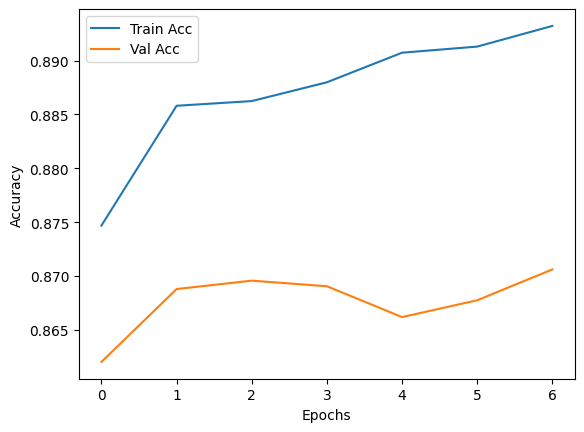

In [133]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [134]:
model.save("f1_podium_model.h5")


In [ ]:
X_cat_columns = X_cat.columns
pd.Series(X_cat_columns).to_pickle("X_cat_columns_train.pkl")
print("Saved X_cat_columns_train.pkl with", len(X_cat_columns), "columns")


Saved X_cat_columns_train.pkl with 1071 columns


In [141]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

model = load_model("f1_podium_model.h5")              
scaler = joblib.load("scaler.save")                   
X_cat_columns = pd.read_pickle("X_cat_columns_train.pkl") 
numeric_cols = ['grid']                          

def prepare_input(driver, constructor, circuit, grid):
  
    total_features = len(numeric_cols) + len(X_cat_columns)
    X_input = np.zeros((1, total_features), dtype=float)
    X_input[0, :len(numeric_cols)] = scaler.transform([[grid]])
    for i, col in enumerate(X_cat_columns):
        if col.lower() in [driver.lower(), constructor.lower(), circuit.lower()]:
            X_input[0, len(numeric_cols) + i] = 1.0

    return X_input
def predict_podium(driver, constructor, circuit, grid, threshold=0.5):
    X_input = prepare_input(driver, constructor, circuit, grid)
    prob = model.predict(X_input, verbose=0)[0][0]
    return prob, "PODIUM ✅" if prob >= threshold else "Not Podium ❌"


if __name__ == "__main__":
    driver = "Lewis Hamilton"
    constructor = "Mercedes"
    circuit = "Silverstone Circuit"
    grid = 2

    prob, result = predict_podium(driver, constructor, circuit, grid)
    print(f"Driver: {driver}, Constructor: {constructor}, Circuit: {circuit}, Grid: {grid}")
    print(f"Podium Probability: {prob:.2f} → {result}")


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Driver: Lewis Hamilton, Constructor: Mercedes, Circuit: Silverstone Circuit, Grid: 2
Podium Probability: 1.00 → PODIUM ✅
